In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# sys.path.append(os.path.abspath("../model_utils"))
sys.path.append(os.path.abspath("../classificador"))
sys.path.append(os.path.abspath("../evaluacion"))

import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier_model = torch.load('../classificador/1711206440837-resnext29_8_64_sgd_plateau_bs96_lr1.0e-02_wd1.0e-03-best-loss.pth', map_location=device)
classifier_model.eval();

In [47]:
# classifier_model

In [4]:
import utils_fid as uf


gen_data, gen_paths = uf.get_embedding(classifier_model, '../data/embedding', class_c='BOAFAB_GENERATED', sample_size=1000, batch_processing=2)
real_data, real_paths = uf.get_embedding(classifier_model, '../data/embedding', class_c='BOAFAB_REAL', sample_size=1000)

 25%|██▍       | 478/1940 [00:43<02:00, 12.16audios/s]

In [ ]:
fid_score = uf.calculate_fid(real_data, gen_data)
fid_score


116.7889120737893

In [8]:
## clusterin generative data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(gen_data)

In [46]:
fid_score = uf.calculate_fid(real_data, gen_data[~kmeans.labels_.astype(bool)])
fid_score

9.749175071716309

In [ ]:
data = np.vstack((
    real_data,
    gen_data
))
grouper = ['Real'] * len(real_data) + ['Generated'] * len(gen_data)
scaled_real_data = scale(data)

dim_new_dimension = 2

pca = PCA(n_components=dim_new_dimension)
pca.fit(scaled_real_data)

data_transformed = pca.transform(scaled_real_data)

c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


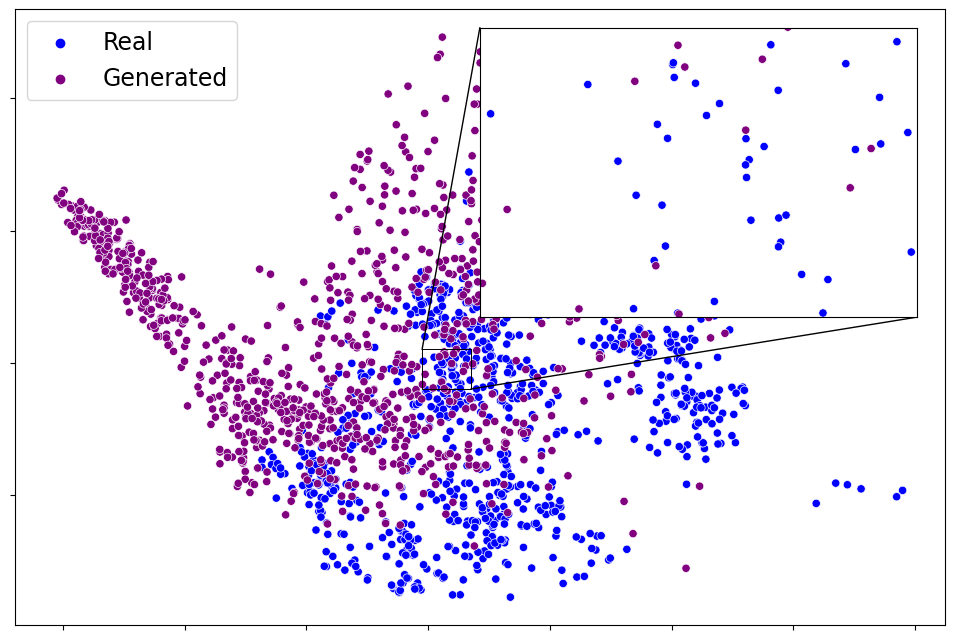

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=ax
)
x1, x2, y1, y2 = -1, 7, -2, 1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# # Add labels from the 'labels' column
# for i, (x, y) in enumerate(data_transformed):
#     plt.text(x, y, i, fontsize=10)



sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=axins
)
ax.indicate_inset_zoom(axins,  edgecolor="black", alpha=1,lw=0.7)
axins.get_legend().set_visible(False)

axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [18]:
kmeans.labels_.shape

(1000,)

In [19]:
import pandas as pd
import plotly.express as px

df_audios = pd.DataFrame(data_transformed, columns=['x', 'y'])
df_audios['num'] = df_audios.index
df_audios['type'] = grouper

In [25]:
df_audios['group'] = 2
df_audios.loc[df_audios['type'] ==  'Generated', 'group'] = kmeans.labels_

In [27]:
fig = px.scatter(df_audios, x="x", y="y", color="group", hover_name='num', color_discrete_sequence=['blue', 'purple'])

fig.show()


In [28]:
import librosa
paths = real_paths + gen_paths
def load_audio(path, verbose=False):
    audio, sr = librosa.load(path, sr=16_000)

    return audio, sr

In [39]:
from IPython.display import Audio

load_path = paths[994]
print(load_path)
audio, sr = load_audio(load_path)

Audio(data=audio, rate=16_000)

../data/embedding\BOAFAB_REAL\994.wav
